In [1]:
from math import ceil
import subprocess
import sys

import pandas as pd
import pegasus as pg
import numpy as np

import paths
from config import do_counts, do_genes, do_mito, do_ribo, OUTPUT_DIR, DATA_DIR
from filters import filter_cells, initial_qc
from local_config import local
from readers import auto_reader
from utils import cluster_data, safe_mkdir, add_cd_scores, title

TASKS_PER_TISS = 1  # how many different methods per one tissue. Used to determine method and param from task id
DATA_DIR = "/Users/michaelalperovich/Documents/primes_storage/data/"
#DATA_DIR = "/Volumes/easystore/primes_storage/data/"

project = "mc_hca"
task_id = 31
res = 1.4

In [2]:
def get_ncols(arr, n_rows=4):
    return max(3, ceil(len(arr) / n_rows))

def make_plots(markers):
    pg.dotplot(adata, genes=markers, groupby='louvain_labels', switch_axes=True)
    pg.scatter(adata, attrs="clusters", basis='umap', legend_loc='on data')
    pg.scatter(adata, attrs="clusters", basis='umap')
    for i in range(0, len(markers) + len(markers) % 2, 2):
        pg.scatter(adata, attrs=markers[i:min(i + 2, len(markers))], basis='umap', ncols=2, cmap="cool")

In [3]:
tissue, is_human, adata = auto_reader(project, task_id, TASKS_PER_TISS)  # read the data for current task id
method, param = "mad", 2
adata = initial_qc(adata, 100, 3, is_human)
pg.log_norm(adata)

2020-10-09 19:41:02,255 - pegasusio.readwrite - INFO - tsv file '/Volumes/easystore/primes_storage/data/HCA/GSM4008661_Adult-Trachea2_dge.txt' is loaded.
2020-10-09 19:41:02,259 - pegasusio.readwrite - INFO - Function 'read_input' finished in 9.16s.
2020-10-09 19:41:02,373 - pegasusio.aggr_data - INFO - Function 'aggregate' finished in 0.11s.
2020-10-09 19:41:02,375 - pegasusio.data_aggregation - INFO - Aggregated 1 files.
2020-10-09 19:41:02,377 - pegasusio.data_aggregation - INFO - Function 'aggregate_matrices' finished in 9.28s.
2020-10-09 19:41:04,046 - pegasusio.qc_utils - INFO - After filtration, 10000 out of 10000 cell barcodes are kept in UnimodalData object GRCh38-rna.
2020-10-09 19:41:04,182 - pegasus.tools.preprocessing - INFO - After filtration, 24990/24990 genes are kept. Among 24990 genes, 17950 genes are robust.
2020-10-09 19:41:04,479 - pegasus.tools.preprocessing - INFO - Function 'log_norm' finished in 0.30s.


In [4]:
task_directory = str(res) + "-" + method + "-" + str(param)
results_dir = OUTPUT_DIR + project + "/" + tissue + "/" + task_directory + "/"  # directory for saving output
cells = pd.read_csv(results_dir + "!cells.csv")

adata.obs["is_mad2"] = False
adata.obs["is_mad2"][cells["barcodekey"]] = True
adata.obs["passed_qc"] = (adata.obs.is_mad2)
pg.filter_data(adata)

2020-10-09 19:41:04,686 - pegasusio.qc_utils - INFO - After filtration, 9253 out of 10000 cell barcodes are kept in UnimodalData object GRCh38-rna.


<ipython-input-4-a36ac2b9b230>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["is_mad2"][cells["barcodekey"]] = True


In [5]:
cells.index = cells.barcodekey
cells.louvain_labels = [t - 1 for t in cells.louvain_labels]
cells = cells.reindex(adata.obs.index)
adata.obs["louvain_labels"] = cells.louvain_labels
adata.obs["clusters"] = [str(t) for t in adata.obs["louvain_labels"]]
adata.obs["Channel"] = cells.Channel
x_umap = np.array([[cells.umap1[i], cells.umap2[i]] for i in range(len(cells.umap1))], dtype="float32")
adata.obsm["X_umap"] = x_umap

In [ ]:
genes = dict()
cls = ["Epithelial", "Immune", "Stromal"]
for c in cls:
    genes[c] = set()
with open(DATA_DIR + "ct_markers.csv", "r") as fin:
    header = []
    for line in fin.readlines():
        if not header:
            for ct in line.strip().split(","):
                genes[ct] = set()
                header.append(ct)
        else:
            l = line.strip().split(",")
            for i in range(len(l)):
                if l[i]:
                    if is_human:
                        gene = l[i]
                    else:
                        gene = title(l[i])
                    if gene in adata.var_names:
                        genes[header[i]].add(gene)
                        for c in cls:
                            if c in header[i]:
                                genes[c].add(gene)
for k in genes.keys():
    genes[k] =  sorted(list(genes[k]))

In [ ]:
make_plots(genes["Epithelial"])

In [ ]:
make_plots(genes["Immune/B Cell"])

In [ ]:
make_plots(genes["Immune/Dendritic"])

In [ ]:
make_plots(genes["Immune/Dendritic/Plasmacytoid"])

In [ ]:
make_plots(genes["Immune/Macrophage"])

In [ ]:
make_plots(genes["Immune/Monocyte"])

In [ ]:
make_plots(genes["Immune/Myeoid"])

In [ ]:
make_plots(genes["Immune/NK"])

In [ ]:
make_plots(genes["Immune/Plasma"])

In [ ]:
make_plots(genes["Immune/T Cell"])

In [ ]:
make_plots(genes["Stromal/Endothelial"])

In [ ]:
make_plots(genes["Stromal/Fibroblast"])

In [ ]:
make_plots(genes["Stromal/Pericyte"])

In [ ]:
make_plots(genes["Stromal/Smooth Muscle"])

In [ ]:
make_plots(genes["Stromal/Various"])

In [ ]:
make_plots(genes["Cycling"])

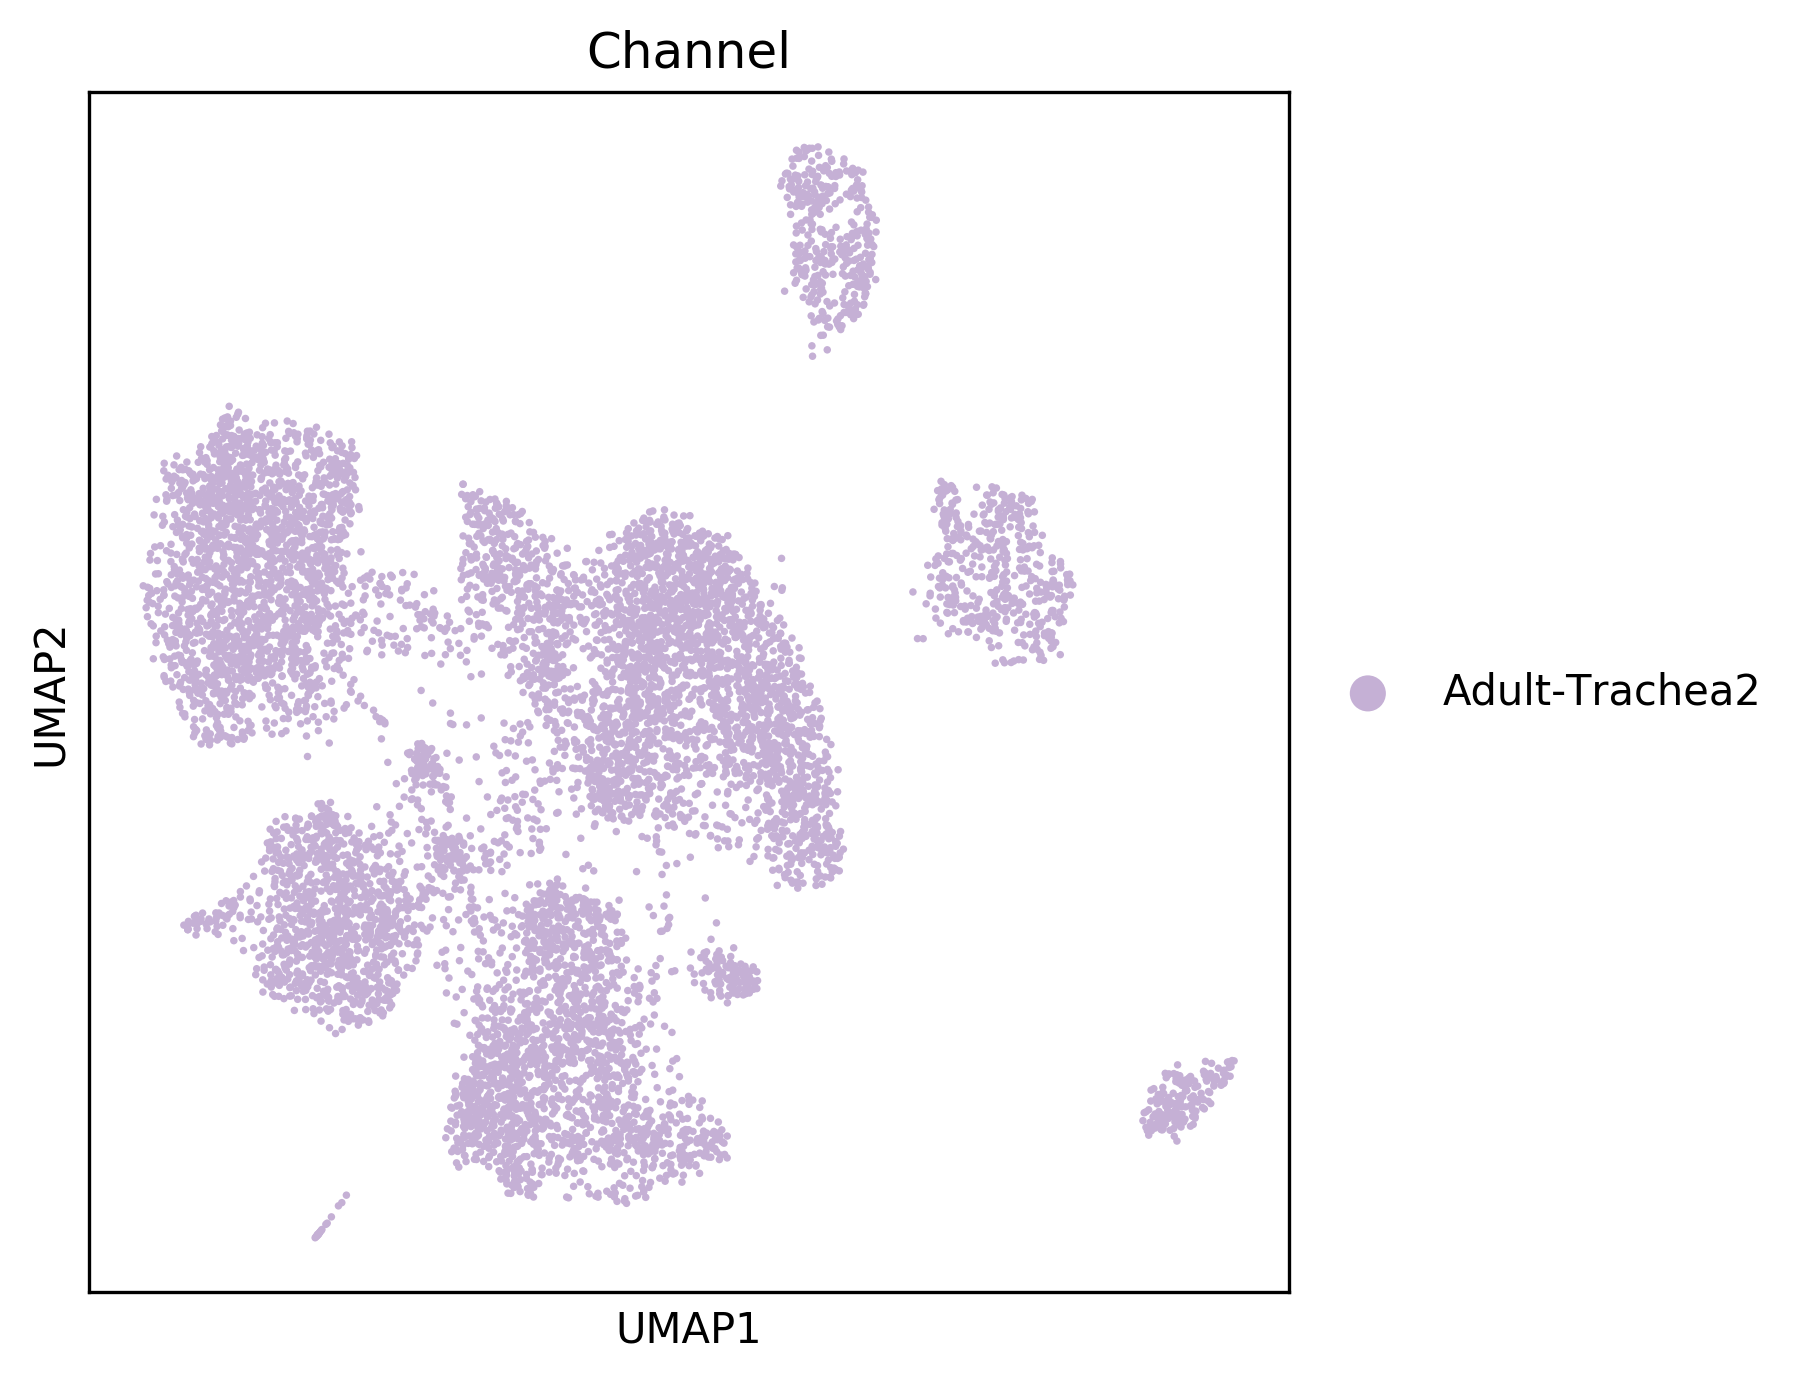

In [6]:
pg.scatter(adata, attrs="Channel", basis='umap')